In [206]:
import numpy as np
import random
import matplotlib.pyplot as plt
import imageio
import glob
import os
import scipy.io
from scipy import signal
from scipy import ndimage
import math

from keras.utils import to_categorical #for one hot encoding

#To make it compatible with jupyter notebook
%matplotlib inline
# Fixing random state for reproducibility
np.random.seed(1)

## Dataset Preparation:

In [2]:
%run "Dataset_generator.ipynb"

In [3]:
def print_shapes_of_dataset():
    print("Train X shape: \t" + str(train_set_X.shape))  #can make (60000, 28, 28, 1) but i think there is no need
    print("Train Y shape: \t" + str(train_set_Y.shape))
    print("Test X shape: \t" + str(test_set_X.shape))
    print("Test Y shape: \t" + str(test_set_Y.shape))
print_shapes_of_dataset()

Train X shape: 	(60000, 28, 28)
Train Y shape: 	(60000, 1)
Test X shape: 	(10000, 28, 28)
Test Y shape: 	(10000, 1)


In [4]:
train_set_Y = train_set_Y.T
test_set_Y = test_set_Y.T

In [5]:
print_shapes_of_dataset()

Train X shape: 	(60000, 28, 28)
Train Y shape: 	(1, 60000)
Test X shape: 	(10000, 28, 28)
Test Y shape: 	(1, 10000)


In [119]:
# one hot encode
encoded_train_Y = to_categorical(train_set_Y)
encoded_train_Y = encoded_train_Y.reshape(encoded_train_Y.shape[1], encoded_train_Y.shape[2])
encoded_train_Y = encoded_train_Y.T
print(encoded_train_Y.shape)

# one hot encode
encoded_test_Y = to_categorical(test_set_Y)
encoded_test_Y = encoded_test_Y.reshape(encoded_test_Y.shape[1], encoded_test_Y.shape[2])
encoded_test_Y = encoded_test_Y.T
print(encoded_test_Y.shape)

(10, 60000)
(10, 10000)


Label: 	5


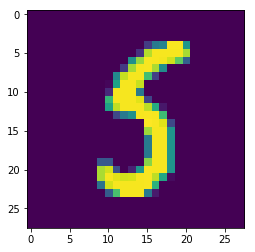

In [6]:
def visualize_img_from_trainset (index = 30800):
    print("Label: \t" + str(train_set_Y[0, index]))
    plt.imshow(train_set_X[index])
visualize_img_from_trainset (index = 0)

(5, 5, 3)
2.1855754065331614
(28, 28)
(24, 24)


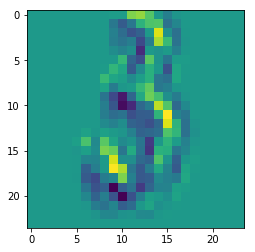

In [7]:
filter_01 = np.random.randn(5,5, 3)
print(filter_01.shape)
print(np.amax(filter_01))
print(train_set_X[30800].shape)
conv = signal.convolve2d(train_set_X[30800], filter_01[:, :, 0], mode = 'valid')
print(conv.shape)
plt.imshow(conv)

## Convolution Functions:

In [47]:
def init_conv(kernel_dims):
    '''
    kernel_dims = [H, W, # of kernels] or [H, W, C, # of kernels] 
    '''
    if(len(kernel_dims) == 3):
        kernels = np.random.randn(kernel_dims[0], kernel_dims[1], kernel_dims[2]) * 0.01
    else:
        kernels = np.random.randn(kernel_dims[0], kernel_dims[1], kernel_dims[2], kernel_dims[3]) * 0.01
    
    return kernels 

In [10]:
def conv_forward(img, filters, stride = 1, pad = 0):
    '''
    img  = 2D
    filters = 2D with 3rd dimesion representing # of filters
    '''
    conv_mat = None
    img_rows = img.shape[0]
    img_cols = img.shape[1]
    flt_rows = filters.shape[0]
    flt_cols = filters.shape[1]
    n_h = int((img_rows - flt_rows + (2*pad))/stride) + 1
    n_w = int((img_cols - flt_cols + (2*pad))/stride) + 1
    
    if(len(filters.shape) == 3):
        n_c = filters.shape[2] 
        conv_mat = np.zeros((n_h, n_w, n_c))
        for i in range(0, n_c):
            conv_mat[:, :, i] = signal.convolve(img, filters[:, :, i], mode = 'valid')
    else:
        n_c = filters.shape[3] 
        conv_mat = np.zeros((n_h, n_w, n_c))
        for i in range(0, n_c):
            conv_mat[:, :, i] = signal.convolve(img, filters[:, :, :,i], mode = 'valid').reshape((n_h, n_w))
        
    return conv_mat

## Pooling Functions

In [11]:
def pool_forward(feature_map, mode = "max", filter_size = 2, stride = 2):
    
    n_c = feature_map.shape[2]
    f_rows = feature_map.shape[0]
    f_cols = feature_map.shape[1]
    
    n_h = int((f_rows - filter_size)/stride) + 1
    n_w = int((f_rows - filter_size)/stride) + 1
    
    poolout = np.zeros((n_h, n_w, n_c))
    
    if (mode == "max"):
        for c in range(0, n_c):
            for i in range(0, n_h):
                for j in range(0, n_w):
                    pool_max = np.amax(feature_map[(i*stride):((i*stride)+filter_size), (j*stride):((j*stride)+filter_size),c])
                    poolout[i, j, c] = pool_max
    else:
        print("Wrong Way bro")
    return poolout

# FC Layers Functions

In [12]:
# %run FC_Layer_functions.ipynb

In [13]:
def init_network(no_of_layers, input_dim, neurons_per_layer):
    '''
    no_of_layers: count
    input_dim: m
    neurons_per_layer: list in order L1, L2, L3 ... Lout
    
    returns:
    net:    dict instance
    '''
    net = {
        "no_of_layers": no_of_layers,
        "W1": np.random.randn(neurons_per_layer[0], input_dim)*0.01,
        "b1": np.zeros((neurons_per_layer[0], 1))
    }
    
    for i in range(1, no_of_layers):
        net["W"+str(i+1)] = np.random.randn(neurons_per_layer[i], neurons_per_layer[i-1])*0.01
        net["b"+str(i+1)] = np.zeros((neurons_per_layer[i], 1))

    return net

In [14]:
def sigmoid (x):
    '''
    Parameters:
    x - input
    
    Returns:
    answer - The sigmoid vaue of 'x'
    '''
    answer = 1/(1 + np.exp(-x))
    return answer

In [15]:
def ReLU(x):
    
    if(len(x.shape) == 3):
        return np.maximum(np.zeros((x.shape[0], x.shape[1], x.shape[2])), x)
    elif(len(x.shape) == 4):
        return np.maximum(np.zeros((x.shape[0], x.shape[1], x.shape[2], x.shape[3])), x)

In [219]:
def ReLU_derivative(x):
    dx = np.zeros((x.shape))
    
    for i in range(0, dx.shape[0]):
        for j in range(0, dx.shape[1]):
            for k in range(0, dx.shape[2]):
                if (x[i, j, k] > 0):
                    dx[i, j, k] = 1
    return dx

In [16]:
def softmax(Z):
    A = []
    exp_Z = []
    for i in range(0, Z.shape[0]):
        exp_Z.append(np.exp(Z[i, :]))
    
    exp_Z = np.array(exp_Z)
    sum_exp_Z = np.sum(exp_Z, axis = 0, keepdims = True)
    
    for i in range(0, Z.shape[0]):
        ans = (exp_Z[i, :] / sum_exp_Z)
        A.append(ans)
    
    A = np.array(A)
    A = A.reshape((A.shape[0], A.shape[2]))
    return A

In [17]:
def  forwardPropagation (A_prev, W, b, activation):
    '''
    Parameters:
    model = perceptron class instance, where it is the model initialized using initializeParameters
    X =     [[all dim1 vals], [all dim2 vals]]    i.e.inputs stacked vertically

    Returns:
    modelOutput = The class instance with 'x', 'Z1', 'A1' and 'Z2', 'A2' in it
    '''
    
    Z = np.dot(W, A_prev) + b
    
    if(activation == "sigmoid"):
        A = sigmoid(Z)
    elif(activation == "softmax"):
        A = softmax(Z)
    else:
        print("wrong activation")
        
    return A, Z

In [18]:
def feedForward(net, X):
    '''
    net:   
    X:     
    
    return:
    net:       
    '''
    no_of_layers = net["no_of_layers"]
    net["X"] = X
    
    A_prev = X
    activation = "sigmoid"
    
    for i in range(1, no_of_layers):
        W = net["W"+str(i)]
        b = net["b"+str(i)]
        net["AL"+str(i)], net["ZL"+str(i)] = forwardPropagation (A_prev, W, b, activation)
        A_prev = net["AL"+str(i)]
    
    W = net["W"+str(no_of_layers)]
    b = net["b"+str(no_of_layers)]
    net["AL"+str(no_of_layers)], net["ZL"+str(no_of_layers)] = forwardPropagation (A_prev, W, b, activation = "softmax")
        
    return net

In [19]:
def CostCalculation(m, net_out, encoded_Y):
    '''
    net_out:  
    Y: ground truth
    
    reutrn:
    cost
    '''
    
    cost = (1/(2*m)) * np.sum(np.power(abs(encoded_Y - net_out), 2), axis = 1, keepdims = True)
    
    return cost

In [20]:
def BackProp(net, encoded_Y):
    '''
    parms:
    net =  dict
    encoded_Y =    one hot encoded GT 
    
    returns:
    gradients =   
    '''
    gradients = {}
    no_of_layers = net["no_of_layers"]
    
    m = encoded_Y.shape[1]
    W = net["W"+str(no_of_layers)]
    b = net["b"+str(no_of_layers)]
    Z = net["ZL"+str(no_of_layers)]
    A = net["AL"+str(no_of_layers)]
    
    dZ = (A - encoded_Y) * (A*(1-A))
    
    dW = (1/m)*(np.dot(dZ, net["AL"+str(no_of_layers-1)].T))
    db = (1/m)*(np.sum(dZ, axis = 1, keepdims = True))
    gradients["dW"+str(no_of_layers)] = dW
    gradients["db"+str(no_of_layers)] = db
    
    for i in range(1, no_of_layers-1):
        dZ = np.dot(net["W"+str(no_of_layers -i+1)].T, dZ) * (net["AL"+str(no_of_layers -i)] - (net["AL"+str(no_of_layers -i)]*net["AL"+str(no_of_layers -i)]))
        dW = (1/m)*(np.dot(dZ, net["AL"+str(no_of_layers -i-1)].T))
        db = (1/m)*(np.sum(dZ, axis = 1, keepdims = True))
        gradients["dW"+str(no_of_layers -i)] = dW
        gradients["db"+str(no_of_layers -i)] = db
    
    i = no_of_layers - 1    
    dZ = np.dot(net["W"+str(no_of_layers -i+1)].T, dZ) * (net["AL"+str(no_of_layers -i)] - (net["AL"+str(no_of_layers -i)]*net["AL"+str(no_of_layers -i)]))
    dW = (1/m)*(np.dot(dZ, net["X"].T))
    db = (1/m)*(np.sum(dZ, axis = 1, keepdims = True))
    gradients["dW"+str(no_of_layers -i)] = dW
    gradients["db"+str(no_of_layers -i)] = db
    
    
    return gradients

In [21]:
def  weightUpdate (net, gradients, lr_rate):
    '''
    
    '''
    
    no_of_layers = net["no_of_layers"]
    
    for i in range(1, no_of_layers+1):
        net["W"+str(i)] = net["W"+str(i)] - (lr_rate * gradients["dW"+str(i)])
        net["b"+str(i)] = net["b"+str(i)] - (lr_rate * gradients["db"+str(i)])
        

    return net

In [120]:
def train_Model(net, train_X, encoded_train_Y, test_X, encoded_test_Y, numberofEpochs = 100, lr_rate = 0.1):
    '''
    
    '''
    
    #after flatten
    no_of_layers = net["no_of_layers"]
    All_Train_Loss = []
    All_Test_Loss = []
    
    m = train_X.shape[1]
    
    
    for i in range(1, numberofEpochs+1):
        trn_net = feedForward(net, train_X)
        trn_loss = CostCalculation(train_X.shape[1], trn_net["AL"+str(no_of_layers)], encoded_train_Y)
        All_Train_Loss.append((1/10)*np.sum(trn_loss, axis = 0, keepdims = True))
        
        trn_grads = BackProp(trn_net, encoded_train_Y)
        net = weightUpdate(trn_net, trn_grads, lr_rate)    
        
        tst_net = feedForward(net, test_X)
        tst_loss = CostCalculation(test_X.shape[1], tst_net["AL"+str(no_of_layers)], encoded_test_Y)
        All_Test_Loss.append((1/10)*np.sum(tst_loss, axis = 0, keepdims = True))
        
        if((i%50 == 0) or (i in range(1, 10+1))):
            print("epoch #"+ str(i) + ": \tTrain Loss = "+ str(All_Train_Loss[-1]) + "\t\t Validation Loss = " + str(All_Test_Loss[-1]))
    
    out = {
        "net": net,
        "All_Train_Loss": All_Train_Loss,
        "All_Test_Loss": All_Test_Loss
    }
    return out

# Using above Functions for demo

## Forward Prop for 1 example

In [278]:
NET = init_network(2, 100, [50, 10])
NET["K_l1"] = init_conv([5, 5, 3])
NET["K_l2"] = init_conv([3, 3, 3, 4])

In [279]:
print(NET["K_l1"].shape)
print(NET["K_l2"].shape)

(5, 5, 3)
(3, 3, 3, 4)


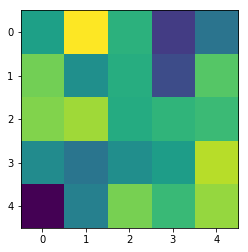

In [311]:
plt.imshow(NET["K_l1"][:, :, 0])

In [280]:
NET["C_l1"] = conv_forward(train_set_X[0], NET["K_l1"])
print(NET["C_l1"].shape)

(24, 24, 3)


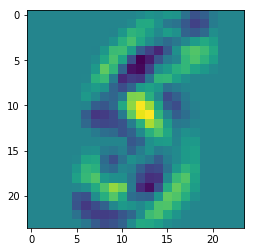

In [281]:
plt.imshow(NET["C_l1"][:,:,0])

In [282]:
NET["CA_l1"] = ReLU(NET["C_l1"])

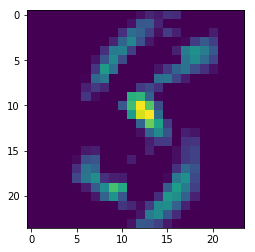

In [283]:
plt.imshow(NET["CA_l1"][:,:,0])

In [284]:
NET["P_l1"] = pool_forward(NET["CA_l1"])
print(NET["P_l1"].shape)

(12, 12, 3)


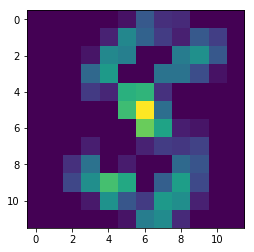

In [285]:
plt.imshow(NET["P_l1"][:,:,0])

In [286]:
NET["C_l2"] = conv_forward(NET["P_l1"], NET["K_l2"])
NET["C_l2"].shape

(10, 10, 4)

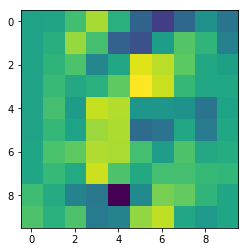

In [287]:
plt.imshow(NET["C_l2"][:,:,0])

In [288]:
NET["CA_l2"] = ReLU(NET["C_l2"])

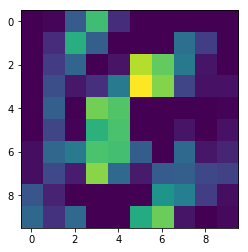

In [289]:
plt.imshow(NET["CA_l2"][:,:,0])

In [290]:
NET["P_l2"] = pool_forward(NET["CA_l2"])
print(NET["P_l2"].shape)

(5, 5, 4)


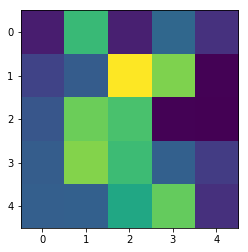

In [291]:
plt.imshow(NET["P_l2"][:,:,0])

In [292]:
NET["F_l3"] = NET["P_l2"].reshape(NET["P_l2"].shape[0]*NET["P_l2"].shape[1]*NET["P_l2"].shape[2], 1)
print(NET["F_l3"].shape)

(100, 1)


In [293]:
NET = feedForward(NET, NET["F_l3"])

In [294]:
cost = CostCalculation(1, NET["AL"+str(2)], np.array(encoded_train_Y[:, 0]).reshape(10,1))
print(np.sum(cost))

0.4527832767957703


In [295]:
print(NET["W"+str(2)].shape)
print(NET["b"+str(2)].shape)
print(NET["AL"+str(2)].shape)


(10, 50)
(10, 1)
(10, 1)


## Back Prop for 1 example

In [296]:
encoded_Y = np.array(encoded_train_Y[:, 0]).reshape(10,1)
gradients = {}
no_of_layers = NET["no_of_layers"]

m = encoded_Y.shape[1]
W = NET["W"+str(no_of_layers)]
b = NET["b"+str(no_of_layers)]
Z = NET["ZL"+str(no_of_layers)]
A = NET["AL"+str(no_of_layers)]
    
dZ = (A - encoded_Y) * (A*(1-A))
    
dW = (1/m)*(np.dot(dZ, NET["AL"+str(no_of_layers-1)].T))
db = (1/m)*(np.sum(dZ, axis = 1, keepdims = True))
gradients["dW"+str(no_of_layers)] = dW
gradients["db"+str(no_of_layers)] = db
    
for i in range(1, no_of_layers-1):
    dZ = np.dot(NET["W"+str(no_of_layers -i+1)].T, dZ) * (NET["AL"+str(no_of_layers -i)] - (NET["AL"+str(no_of_layers -i)]*NET["AL"+str(no_of_layers -i)]))
    dW = (1/m)*(np.dot(dZ, NET["AL"+str(no_of_layers -i-1)].T))
    db = (1/m)*(np.sum(dZ, axis = 1, keepdims = True))
    gradients["dW"+str(no_of_layers -i)] = dW
    gradients["db"+str(no_of_layers -i)] = db
    
i = no_of_layers - 1    
dZ = np.dot(NET["W"+str(no_of_layers -i+1)].T, dZ) * (NET["AL"+str(no_of_layers -i)] - (NET["AL"+str(no_of_layers -i)]*NET["AL"+str(no_of_layers -i)]))
dW = (1/m)*(np.dot(dZ, NET["X"].T))
db = (1/m)*(np.sum(dZ, axis = 1, keepdims = True))
gradients["dW"+str(no_of_layers -i)] = dW
gradients["db"+str(no_of_layers -i)] = db

In [297]:
gradients

{'dW1': array([[ 1.08221787e-05,  8.59454418e-07,  1.16941208e-06, ...,
          0.00000000e+00,  1.13571585e-05,  4.28245561e-06],
        [ 1.44491640e-05,  1.14749518e-06,  1.56133320e-06, ...,
          0.00000000e+00,  1.51634390e-05,  5.71769374e-06],
        [-6.63683230e-06, -5.27070842e-07, -7.17156133e-07, ...,
          0.00000000e+00, -6.96491515e-06, -2.62626782e-06],
        ...,
        [-3.18648171e-06, -2.53057712e-07, -3.44321628e-07, ...,
          0.00000000e+00, -3.34400113e-06, -1.26092599e-06],
        [-1.84553291e-06, -1.46564888e-07, -1.99422734e-07, ...,
          0.00000000e+00, -1.93676434e-06, -7.30297748e-07],
        [ 1.78550265e-05,  1.41797524e-06,  1.92936045e-06, ...,
          0.00000000e+00,  1.87376657e-05,  7.06543113e-06]]),
 'dW2': array([[ 0.00491255,  0.0049295 ,  0.00494216,  0.00491496,  0.00489975,
          0.00490361,  0.00491482,  0.00490077,  0.00492118,  0.00490481,
          0.00493099,  0.00487214,  0.00491317,  0.00490406,  0.004

In [298]:
NET["dF_l3"] = np.dot(NET["W1"].T, dZ)
print(NET["dF_l3"].shape)

(100, 1)


In [299]:
NET["dP_l2"] = NET["dF_l3"].reshape((NET["P_l2"].shape))
print(NET["dP_l2"].shape)

(5, 5, 4)


In [300]:
NET["dCA_l2"] = np.zeros((NET["CA_l2"].shape))

for c in range(0, NET["dCA_l2"].shape[2]):
    for i in range(0, NET["dCA_l2"].shape[0]):
        for j in range(0, NET["dCA_l2"].shape[1]):
            NET["dCA_l2"][i, j, c] = (1/4)*(NET["dP_l2"][int(i/2), int(j/2), c])

print(NET["dCA_l2"].shape)

(10, 10, 4)


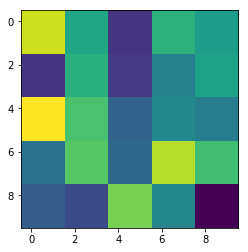

In [301]:
plt.imshow(NET["dCA_l2"][:,:,0])

In [302]:
NET["dC_l2"] = ReLU_derivative(NET["C_l2"])
print(NET["dC_l2"].shape)

(10, 10, 4)


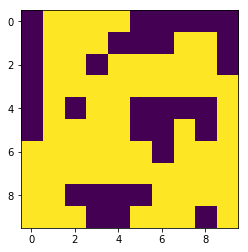

In [303]:
plt.imshow(NET["dC_l2"][:,:,0])

In [319]:
NET["dk_l2"] = signal.convolve(NET["P_l1"], NET["dC_l2"], mode = 'valid')
print(NET["dk_l2"].shape)

ValueError: For 'valid' mode, one must be at least as large as the other in every dimension